In [1]:
import jax.numpy as np
from jax import random, jit, vmap, jacfwd, grad
from jax.example_libraries import optimizers
from jax.nn import sigmoid, softplus
from jax import lax
from jax.tree_util import tree_map, tree_reduce
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
! sudo apt-get install texlive-latex-recommended
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
!apt install cm-super

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 3,
                      'axes.labelsize': 22,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 24,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common texlive-base
  texlive-binaries texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvisvgm fonts-droid-fa

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Helper function to compute dot products between PyTrees
def pytree_dot(x, y):
    partial_dot = tree_map(lambda arr1, arr2: np.sum(arr1 * arr2), x, y)
    return tree_reduce(lax.add, partial_dot)

In [5]:
def mFF_MLP_WN(layers, freqs, activation = np.tanh):
    ''' Multi-scale Fourier features MLP with weight normalization'''
    # Define input encoding function
    def input_encoding(x, w):
        out = np.hstack([np.sin(np.dot(x, w)),
                         np.cos(np.dot(x, w))])
        return out
    # Define linear layer
    def linear(x, w, b, g):
        v = w/np.linalg.norm(w, axis = 0, keepdims=True)
        return np.dot(x, v)*g + b
    # Initialize embedding weights (non-trainable)
    key, *keys = random.split(random.PRNGKey(0), len(freqs)+1)
    init_W = lambda key, freq: freq*random.normal(key, (layers[0], layers[1]//2))
    wFF = vmap(init_W)(*(np.array(keys), np.array(freqs)))
    # Define init function
    def init(rng_key):
        # Initialize neural net params
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            W = random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            g = np.ones(d_out)
            return W, b, g
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[1:-1], layers[2:]))
        return params
    # Define apply function
    def apply(params, inputs):
        H = vmap(input_encoding, in_axes=(None,0))(inputs, wFF)
        for W, b, g in params[:-1]:
            H = vmap(linear, in_axes=(0,None,None,None))(H, W, b, g)
            H = activation(H)
        W, b, g = params[-1]
        H = vmap(linear, in_axes=(0,None,None,None))(H, W, b, g)
        return H.flatten()
    return init, apply

In [6]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, name = None):
        self.dim = dim
        self.coords = coords
        self.name = name

    def sample(self, N, key = random.PRNGKey(1234)):
        x = self.coords.min(1) + (self.coords.max(1)-self.coords.min(1))*random.uniform(key, (N, self.dim))
        return x

In [7]:
class DataGenerator(data.Dataset):
    def __init__(self, dom_sampler, mu_X = 0.0, sigma_X = 1.0, batch_size=64):
        'Initialization'
        self.mu_X = mu_X
        self.sigma_X = sigma_X
        self.dom_sampler = dom_sampler
        self.batch_size = batch_size
        self.key = random.PRNGKey(1234)

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        X = self.__data_generation(subkey)
        return X

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        inputs = self.dom_sampler.sample(self.batch_size, key)
        return inputs

In [8]:
def weights_matrix(neig):
    vec = np.flip(50*(np.arange(neig)+1))
    mat = np.diag(vec)
    return mat

In [9]:
class SPIN:
    # Initialize the class
    def __init__(self, operator, layers, freqs):

        # Callable operator function
        self.operator = operator

        # Network initialization and evaluation functions
        self.net_init, self.net_apply = mFF_MLP_WN(layers, freqs)

        # Initialize network parameters
        params = self.net_init(random.PRNGKey(0))

        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.rmsprop(lr)
        self.opt_state = self.opt_init(params)

        _, self.unravel_params = ravel_pytree(params)


        # Number of eigenvalues
        self.neig = len(freqs)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []
        self.evals_log = []
        self.weights_log = []

    def apply_mask(self, inputs, outputs):
        # mask is used to zero the boundary points.
        mask = 1.0
        if len(inputs.shape) == 2:
            for i in range(inputs.shape[1]):
                mask *= np.maximum((-inputs[:,i]**2 + np.pi * inputs[:,i]) , 0)
                # mask = -inputs[:,i]**2 + np.pi * inputs[:,i]
            mask = np.expand_dims(mask, -1)

        elif len(inputs.shape) == 1:
            for x in inputs:
                mask *= np.maximum((-x ** 2 + np.pi * x ), 0)
                # mask *= (-x ** 2 + np.pi * x)

        return mask*outputs

    def net_u(self, params, inputs):
        outputs = vmap(self.net_apply, in_axes=(None, 0))(params, inputs)
        outputs = self.apply_mask(inputs, outputs)
        return outputs

    def evaluate_spin(self, params, inputs):
        # Fetch batch
        n = inputs.shape[0]
        # Evaluate model
        u = self.net_u(params, inputs)
        sigma = np.dot(u.T, u)/n
        # Cholesky
        chol = np.linalg.cholesky(sigma)
        choli = np.linalg.inv(chol) # $L^{-1}$
        # Operator
        operator = self.operator(self.net_u, params, inputs)
        pi = np.dot(operator.T, u)/n # $\Pi$
        rq = np.dot(choli, np.dot(pi, choli.T)) # $\Lambda$
        return (u, choli, pi, rq, operator)

    def residuals(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, op = outputs
        dl = np.diag(np.diag(rq))
        residuals = np.dot(op, choli.T) - np.dot(np.dot(u, choli.T),dl)
        evals = np.diag(rq)
        loss_residual = np.mean(residuals**2, axis=0)
        # loss_trace = -1.0 * evals
        weight_tr = weights_matrix(self.neig)
        evals = np.dot(weight_tr, evals)
        loss_trace = np.array([-1.0*np.sum(evals)])
        return np.hstack([loss_residual, loss_trace])

    @partial(jit, static_argnums=(0,))
    def loss(self, params, inputs, weights):
        losses = self.residuals(params, inputs)
        return np.dot(weights, losses)/self.neig

    # Define a jit-compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, inputs, weights):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, inputs, weights)
        opt_state = self.opt_update(i, gradients, opt_state)
        return opt_state

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000, ntk_weights = False):
        batch = iter(dataset)
        pbar = trange(nIter)
        # Initialize NTK weights
        if ntk_weights:
            params = self.get_params(self.opt_state)
            weights = self.update_NTK_weights(params, next(batch))
        else:
            weights = np.ones(1 + self.neig)
        # Main training loop
        for it in pbar:
            inputs = next(batch)
            # Run one gradient descent update
            self.opt_state = self.step(next(self.itercount),
                                       self.opt_state,
                                       inputs,
                                       weights)
            # Logger
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                losses = self.residuals(params, inputs)
                evals, _, _ = self.eigenpairs(params, inputs)
                self.loss_log.append(losses)
                self.evals_log.append(evals)
                # pbar.set_postfix({'Loss': np.sum(losses)/(2*self.neig)})
                pbar.set_postfix({'Loss': np.sum(losses)/(1 + self.neig)})
                if ntk_weights:
                    weights = self.update_NTK_weights(params, inputs)
                    self.weights_log.append(weights)


    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def eigenpairs(self, params, inputs):
        outputs = self.evaluate_spin(params, inputs)
        u, choli, _, rq, _ = outputs
        evals = np.diag(rq)
        efuns = np.matmul(u, choli.T)
        return evals, efuns, rq

    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, inputs):
        def body_fn(i, state):
            r_fn = lambda theta: self.residuals(theta, inputs)[i]
            diag = grad(r_fn)(params)
            trace = pytree_dot(diag, diag)
            # state = index_update(state, index[i], trace)
            state = state.at[i].set(trace)
            return state
        # traces = lax.fori_loop(0, 2*self.neig, body_fn, np.zeros(2*self.neig))
        traces = lax.fori_loop(0, 1 + self.neig, body_fn, np.zeros(1 + self.neig))
        weights = np.sum(traces)/traces
        weights = np.sum(traces)/traces
        return weights ** 0.5


In [10]:
def laplacian_2d(u_fn, params, inputs):
    fun = lambda params,x,y: u_fn(params, np.array([[x,y]]))
    def action(params,x,y):
        u_xx = jacfwd(jacfwd(fun, 1), 1)(params,x,y)
        u_yy = jacfwd(jacfwd(fun, 2), 2)(params,x,y)
        return u_xx + u_yy
    vec_fun = vmap(action, in_axes = (None, 0, 0))
    laplacian = vec_fun(params, inputs[:,0], inputs[:,1])
    return np.squeeze(laplacian)

In [11]:
# Problem setup
ndim = 2
neig = 40

# Domain boundaries
dom_coords = np.array([[0.0, np.pi],
                       [0.0, np.pi]])
# Create data sampler
dom_sampler = Sampler(ndim, dom_coords)

dataset = DataGenerator(dom_sampler, batch_size = 256)

In [12]:
# Test data
n_star = 100
xx = np.linspace(0.0, np.pi, n_star)
yy = np.linspace(0.0, np.pi, n_star)
grid = np.meshgrid(xx, yy)
x_star = np.array(grid).T.reshape(-1,ndim)

In [13]:
layers = [ndim, 256, 256, 1]
alpha = 0.8
freqs = list(0.1*(np.arange(neig)+ 3.0)**alpha)
model = SPIN(laplacian_2d, layers, freqs)
print('Frequencies at initialization:\n{}'.format(freqs))

Frequencies at initialization:
[Array(0.24082246, dtype=float32, weak_type=True), Array(0.3031433, dtype=float32, weak_type=True), Array(0.36238983, dtype=float32, weak_type=True), Array(0.41929626, dtype=float32, weak_type=True), Array(0.47432765, dtype=float32, weak_type=True), Array(0.5278032, dtype=float32, weak_type=True), Array(0.5799547, dtype=float32, weak_type=True), Array(0.63095737, dtype=float32, weak_type=True), Array(0.6809484, dtype=float32, weak_type=True), Array(0.7300372, dtype=float32, weak_type=True), Array(0.77831376, dtype=float32, weak_type=True), Array(0.8258524, dtype=float32, weak_type=True), Array(0.8727161, dtype=float32, weak_type=True), Array(0.91895866, dtype=float32, weak_type=True), Array(0.96462643, dtype=float32, weak_type=True), Array(1.0097598, dtype=float32, weak_type=True), Array(1.054394, dtype=float32, weak_type=True), Array(1.0985606, dtype=float32, weak_type=True), Array(1.1422876, dtype=float32, weak_type=True), Array(1.1855999, dtype=float32

In [14]:
ntk_weights = True
model.train(dataset, nIter = 60000, ntk_weights = ntk_weights)

100%|██████████| 60000/60000 [24:07<00:00, 41.44it/s, Loss=22855.518]


In [15]:
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
np.save('Pinn_vmc_params_lapl_2d.npy', flat_params)

In [16]:
# flat_params = np.load('/content/drive/My Drive/Pinn_vmc_params_lapl_2d_new.npy')
opt_params = model.unravel_params(flat_params)

In [17]:
def exact_eigvals(n):
    num = []
    for i in (np.arange(10)+1):
        for j in (np.arange(10)+1):
            num.append( - (i**2 + j**2))
    num = sorted(num, reverse=True)
    return num[0:n]

Predicted eigenvalues: [ -2.0000148  -5.0000405  -5.0000305  -8.000113  -10.000492  -13.000299
 -16.9969    -10.004407  -13.000747  -20.002924  -17.001362  -18.00197
 -25.007168  -25.006502  -29.01137   -20.003977  -26.005508  -26.006355
 -29.009348  -34.01234   -32.011417  -40.03371   -37.01556   -37.015087
 -40.983006  -34.014343  -41.016426  -40.046024  -50.054474  -50.062622
 -50.08954   -45.031483  -52.0274    -45.039303  -52.059822  -53.01509
 -58.094788  -53.06794   -61.124855  -58.11403  ]
Predicted eigenvalues: [Array(-2, dtype=int32), Array(-5, dtype=int32), Array(-5, dtype=int32), Array(-8, dtype=int32), Array(-10, dtype=int32), Array(-10, dtype=int32), Array(-13, dtype=int32), Array(-13, dtype=int32), Array(-17, dtype=int32), Array(-17, dtype=int32), Array(-18, dtype=int32), Array(-20, dtype=int32), Array(-20, dtype=int32), Array(-25, dtype=int32), Array(-25, dtype=int32), Array(-26, dtype=int32), Array(-26, dtype=int32), Array(-29, dtype=int32), Array(-29, dtype=int32), Ar

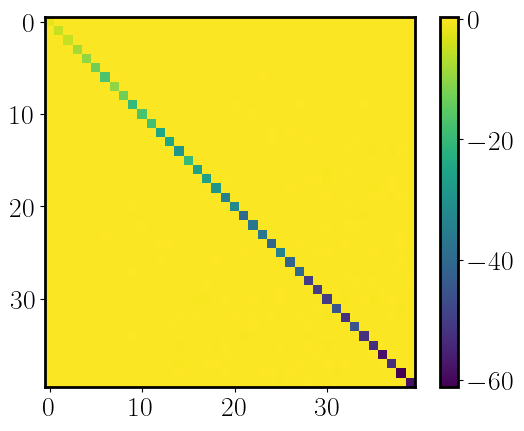

In [18]:
# opt_params = model.get_params(model.opt_state)
evals, efuns, rq = model.eigenpairs(opt_params, x_star)
print('Predicted eigenvalues: {}'.format(evals))
eigvals_exact =  exact_eigvals(40)
print('Predicted eigenvalues: {}'.format(eigvals_exact))

# print("rq: {}".format(rq))
plt.figure()
plt.imshow(rq)
plt.colorbar()
plt.show()

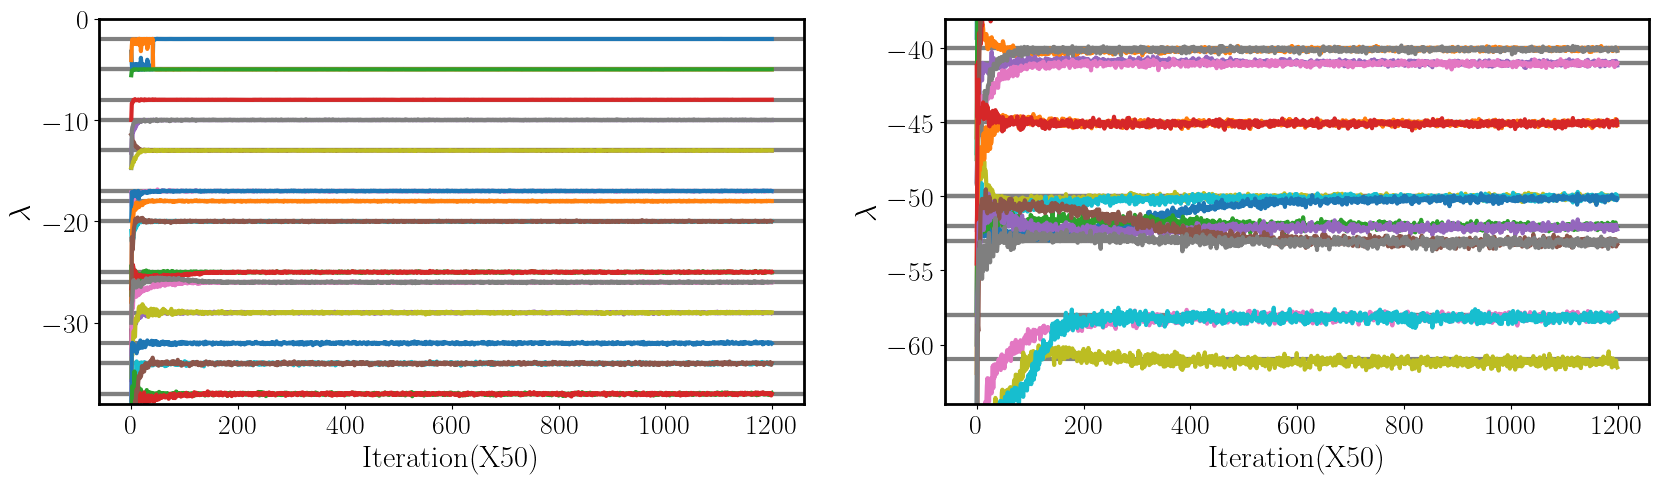

In [19]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
for i in eigvals_exact:
    plt.axhline(i, color = 'gray')
plt.plot(model.evals_log)
plt.xlabel('Iteration(X$50$)')
plt.ylabel('$\lambda$')
plt.ylim([-38,0])

plt.subplot(1,2,2)
for i in eigvals_exact:
    plt.axhline(i, color = 'gray')
plt.plot(model.evals_log)
plt.xlabel('Iteration(X$50$)')
plt.ylabel('$\lambda$')
plt.ylim([-64,-38])
# plt.ylim([-76,-38])


fig.savefig("lapl_2d_eigval_log" + ".pdf", bbox_inches='tight', dpi=600)
plt.show()


# for i in (np.arange(3) + 1):
#     plt.subplot(2,2,i)
#     plt.plot(model.evals_log)
#     for i in eigvals_exact:
#         plt.axhline(i, color = 'gray')
#     plt.xlabel('iteration')
#     plt.ylabel('$\lambda$')
#     plt.tight_layout()

# plt.subplot(2,2,2)
# plt.ylim([-55,-45])

# plt.subplot(2,2,3)
# plt.ylim([-50,-30])

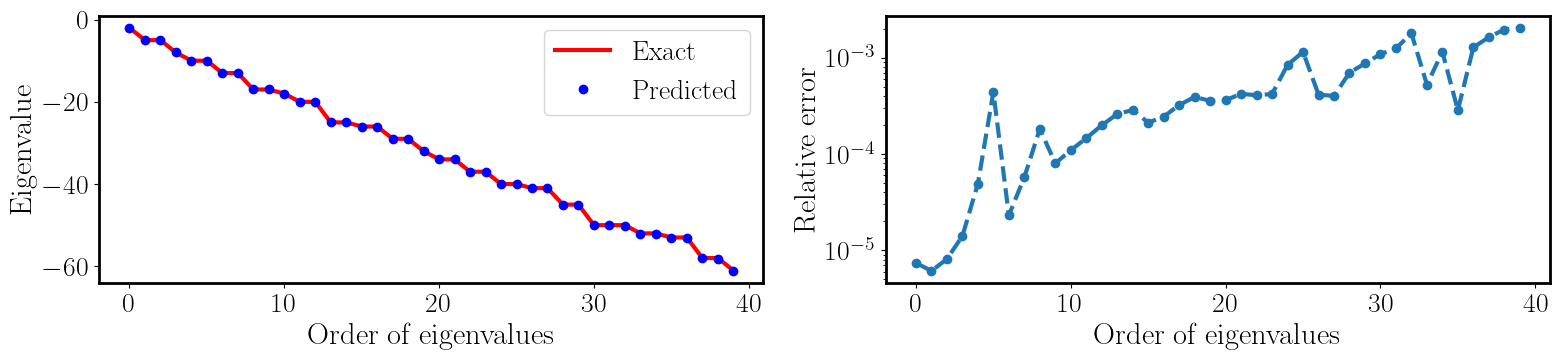

In [20]:
fig = plt.figure(figsize = [16,4])

x = np.arange(40)
plt.subplot(1,2,1)

evals_ = np.flip(np.sort(evals))
plt.plot( x, eigvals_exact,'r')
plt.plot(x, evals_,'b o')
plt.xlabel('Order of eigenvalues')
plt.ylabel('Eigenvalue')
plt.legend(['Exact','Predicted'])
plt.tight_layout()

plt.subplot(1,2,2)
eigvals_exact = np.array(eigvals_exact)
# print(type(eigvals_exact))
error = np.sqrt((evals_ - eigvals_exact)**2/eigvals_exact**2)
plt.plot(x, error,'--o')

plt.xlabel('Order of eigenvalues')
plt.ylabel('Relative error')
plt.yscale('log')
plt.tight_layout()

fig.savefig("lapl_2d_eig_error" + ".pdf", bbox_inches='tight', dpi=600)

plt.show()

0.0103462385
0.010749261
0.01791042
0.04124192


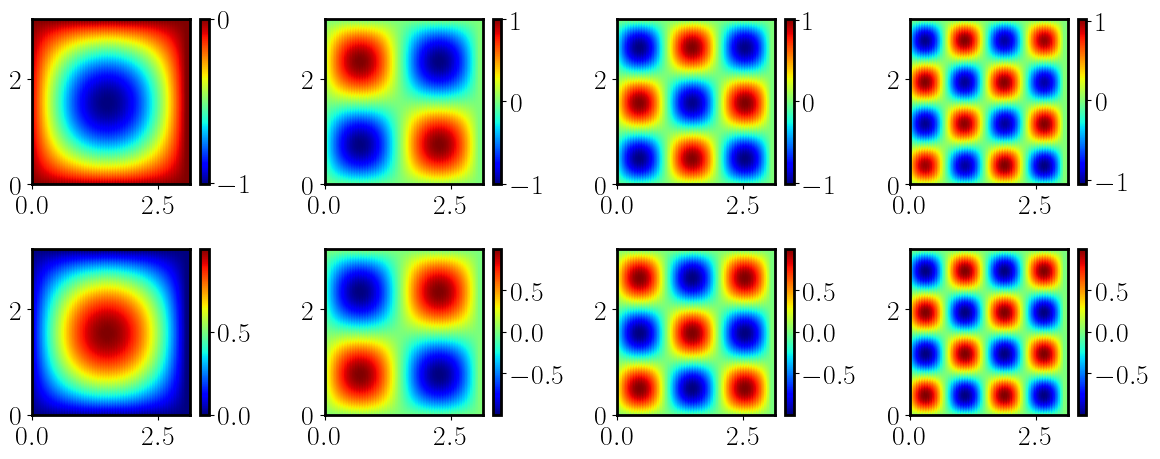

In [28]:
fig = plt.figure(figsize = [12, 5.0])
eigval_ = np.flip(np.sort(evals))
idx = np.array([-2,-8,-18,-32])
for i in np.arange(4):
    inx_pre = np.where(eigvals_exact == idx[i])
    inx = np.where(evals == eigval_[inx_pre])
    m = int(i+1)
    plt.subplot(2,4,m)
    plt.scatter(x_star[:,0], x_star[:,1], c = efuns[:,inx]/2, cmap = 'jet')
    plt.xlim([0,np.pi])
    plt.ylim([0,np.pi])
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    efuns_exact = np.sin((i+1)*x_star[:,0])*np.sin((i+1)*x_star[:,1])
    plt.colorbar()

    n = int(i+5)
    plt.subplot(2,4,n)
    plt.scatter(x_star[:,0], x_star[:,1], c = efuns_exact,cmap = 'jet')
    plt.xlim([0,np.pi])
    plt.ylim([0,np.pi])
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    efuns_pred = np.squeeze(efuns[:,inx])
    error1 = np.linalg.norm(efuns_pred/2 - efuns_exact, 2)/np.linalg.norm(efuns_exact, 2)
    error2 = np.linalg.norm(efuns_pred/2 + efuns_exact, 2)/np.linalg.norm(efuns_exact, 2)
    error = np.min(np.array([error1, error2]))
    plt.colorbar()
    print(error)

# plt.colorbar()

plt.tight_layout()

fig.savefig("lapl_2d_efuns" + ".pdf", bbox_inches='tight', dpi=600)

plt.show()

In [30]:
losses = np.array(model.loss_log)
plt.figure(figsize = (20,4))
plt.subplot(1,2,1)
plt.plot(losses[:,:neig], 'b')
plt.plot(losses[:,neig:], 'r')
plt.yscale('log')
plt.xlabel('Iteration (x50)')
plt.ylabel('Loss')


Text(0, 0.5, 'Loss')

In [31]:
def test_lapl_2d(u):

    def f(x,y):
        u_xx = np.squeeze(jacfwd(jacfwd(u,0),0)(x,y))
        u_yy = np.squeeze(jacfwd(jacfwd(u,1),1)(x,y))
        return u_xx + u_yy

    u_star = u(x_star[:,0], x_star[:,1])
    f_star = vmap(f)(x_star[:,0], x_star[:,1])

    efuncs = np.sum(efuns*efuns, axis = 0)

    c = np.dot(f_star.T, efuns)/efuncs

    w = c/evals

    u_pred = np.sum(w*efuns,1,keepdims=True)

    # plt.figure(figsize=(12,6))
    # plt.subplot(1,2,1)
    # plt.scatter(x_star[:,0], x_star[:,1], c = u_pred)
    # plt.subplot(1,2,2)
    # plt.scatter(x_star[:,0], x_star[:,1], c = u_star)

    error = np.linalg.norm(u_star[:,None] - u_pred, 2)/np.linalg.norm(u_star, 2)
    # print('Relative L2 error: {}'.format(error))

    return u_pred, error


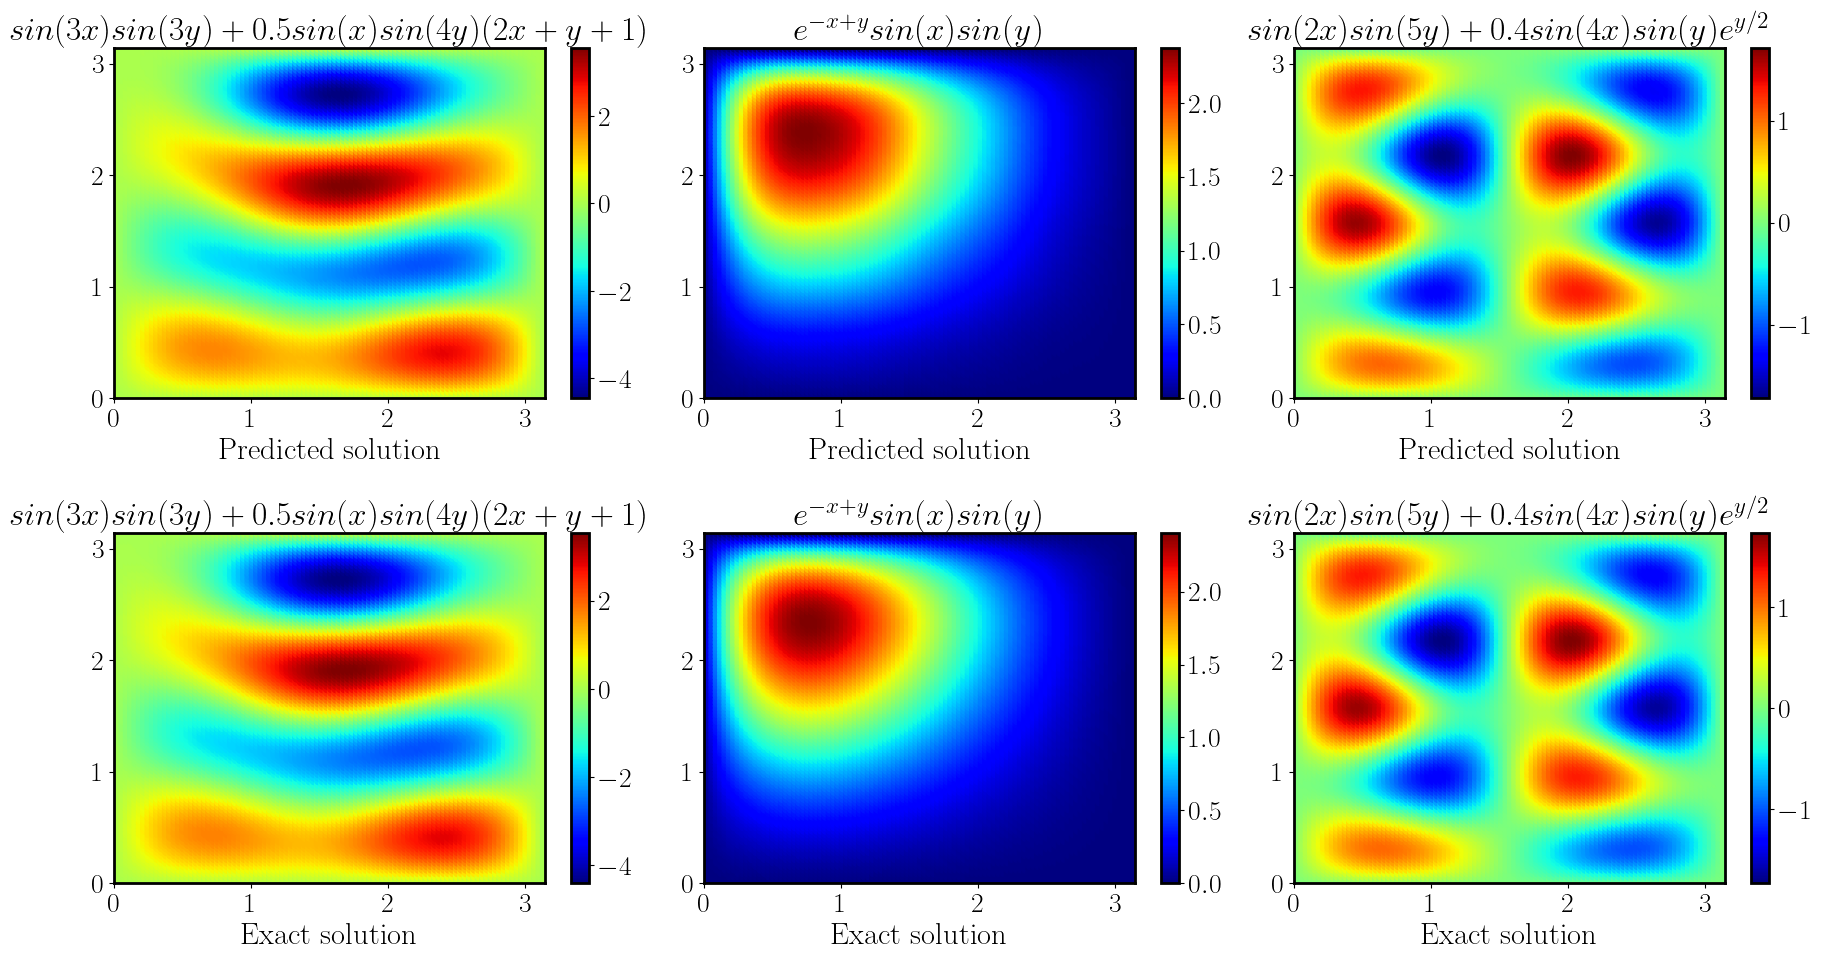

In [33]:
def u(x,y):
    return np.sin(3.0*x)*np.sin(3.0*y) + 0.5*np.sin(1.0*x)*np.sin(4.0*y)*(2*x+y+1)

test_lapl_2d(u)


fig = plt.figure(figsize = [18,10])
u1 = lambda x,y: np.sin(3.0*x)*np.sin(3.0*y) + 0.5*np.sin(x)*np.sin(4.0*y)*(2*x+y+1)
u_pred1, error1 = test_lapl_2d(u1)
u_star1 = u1(x_star[:,0], x_star[:,1])


plt.subplot(2,3,1)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred1,cmap = 'jet')
plt.title('$sin(3x)sin(3y)+0.5sin(x)sin(4y)(2x+y+1)$')
plt.xlabel('Predicted solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(2,3,4)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star1,cmap = 'jet')
plt.title('$sin(3x)sin(3y)+0.5sin(x)sin(4y)(2x+y+1)$')
plt.xlabel('Exact solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

u2 = lambda x,y: np.exp(-x+y)*np.sin(1.0*x)*np.sin(1.0*y)
u_pred2, error2 = test_lapl_2d(u2)
u_star2 = u2(x_star[:,0], x_star[:,1])

plt.subplot(2,3,2)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred2, cmap = 'jet')
plt.title('$e^{-x+y}sin(x)sin(y)$')
plt.xlabel('Predicted solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(2,3,5)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star2,cmap = 'jet')
plt.title('$e^{-x+y}sin(x)sin(y)$')
plt.xlabel('Exact solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

u3 = lambda x,y: np.sin(2*x)*np.sin(5*y) + 0.4*np.sin(4*x)*np.sin(y)*np.exp(0.5*y)
u_pred3, error3 = test_lapl_2d(u3)
u_star3 = u3(x_star[:,0], x_star[:,1])

plt.subplot(2,3,3)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred3,cmap = 'jet')
plt.title('$sin(2x)sin(5y)+0.4sin(4x)sin(y)e^{y/2}$')
plt.xlabel('Predicted solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(2,3,6)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star3,cmap = 'jet')
plt.title('$sin(2x)sin(5y)+0.4sin(4x)sin(y)e^{y/2}$')
plt.xlabel('Exact solution')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()


plt.tight_layout()

plt.show()
fig.savefig("lapl_2d_nonhomo" + ".pdf", bbox_inches='tight', dpi=600)

In [34]:
print(error1)
print(error2)
print(error3)

0.014124679
0.01812581
0.012309034


In [35]:
def test_heat_2d(a,b,t):
    def g(x,y):
        return np.sin(a*x)*np.sin(b*y)

    g_star = g(x_star[:,0],x_star[:,1])

    c_init = np.dot(g_star.T, efuns)/(n_star**2)

    def u_heat_2d(t):
        c_t = c_init * np.exp(evals*t/(a**2 + b**2))
        u = np.dot(efuns, c_t)
        return u

    u_pred = u_heat_2d(t)

    def u_exact_2d(x,y,t):
        u = np.exp(-1.0*t)*np.sin(a*x)*np.sin(b*y)
        return u

    u_star = u_exact_2d(x_star[:,0], x_star[:,1], t)

    # plt.figure(figsize=(12,6))
    # plt.subplot(1,2,1)
    # plt.scatter(x_star[:,0], x_star[:,1], c = u_pred)
    # plt.subplot(1,2,2)
    # plt.scatter(x_star[:,0], x_star[:,1], c = u_star)

    error = np.linalg.norm(u_star - u_pred, 2)/np.linalg.norm(u_star, 2)
    # print("error is: {}".format(error))
    return u_pred, u_star, error

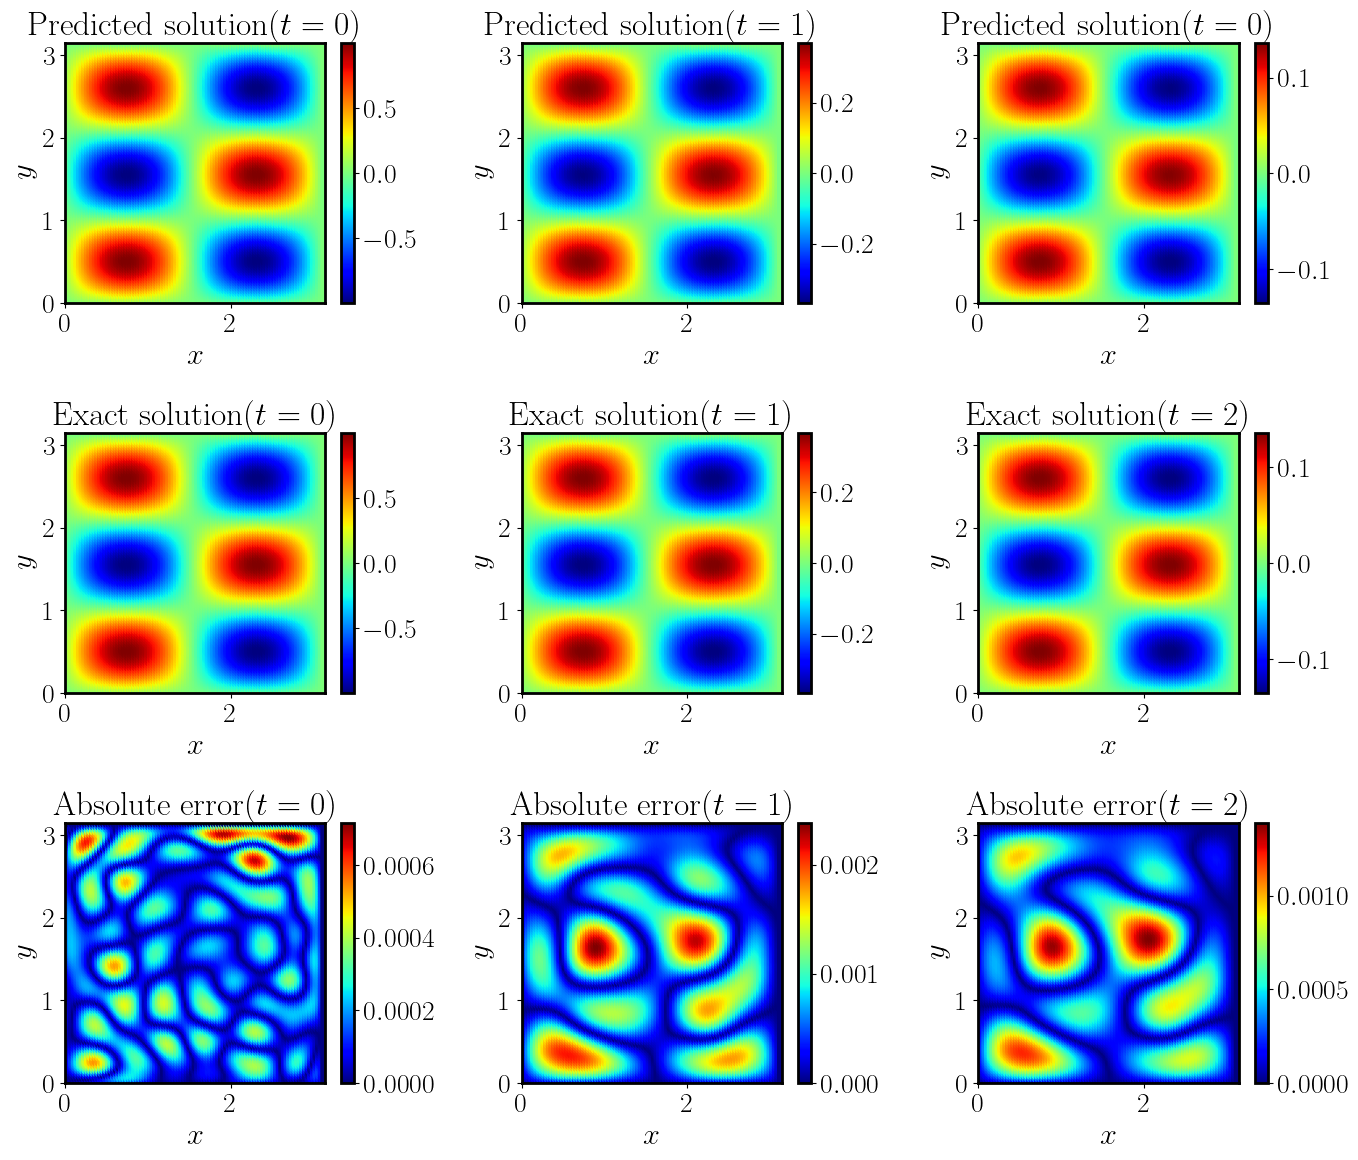

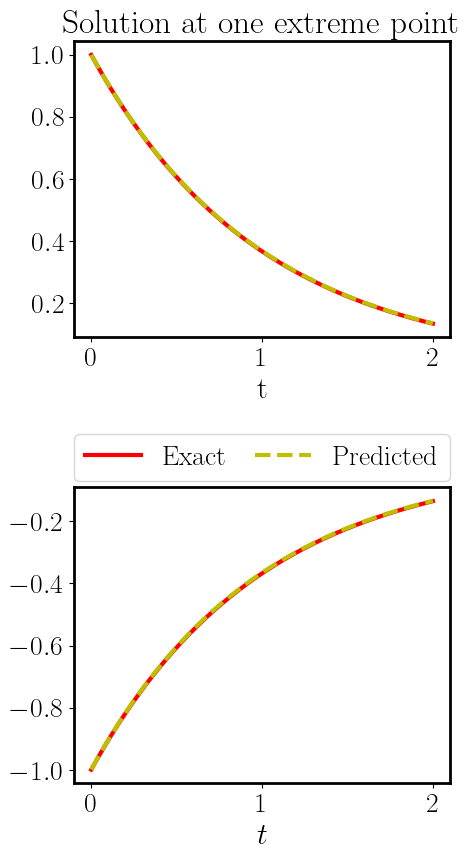

In [38]:
fig = plt.figure(figsize = [14, 12])

u_pred, u_star, error1 = test_heat_2d(2,3,0)
plt.subplot(3,3,1)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred,cmap = 'jet')
plt.title('Predicted solution($t=0$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,4)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star,cmap = 'jet')
plt.title('Exact solution($t=0$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,7)
plt.scatter(x_star[:,0], x_star[:,1], c = abs(u_pred - u_star),cmap = 'jet')
plt.title('Absolute error($t=0$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

u_pred, u_star, error2 = test_heat_2d(2,3,1)
plt.subplot(3,3,2)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred,cmap = 'jet')
plt.title('Predicted solution($t=1$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,5)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star,cmap = 'jet')
plt.title('Exact solution($t=1$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,8)
plt.scatter(x_star[:,0], x_star[:,1], c = abs(u_pred - u_star),cmap = 'jet')
plt.title('Absolute error($t=1$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

u_pred, u_star, error3 = test_heat_2d(2,3,2)
plt.subplot(3,3,3)
plt.scatter(x_star[:,0], x_star[:,1], c = u_pred,cmap = 'jet')
plt.title('Predicted solution($t=0$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,6)
plt.scatter(x_star[:,0], x_star[:,1], c = u_star, cmap = 'jet')
plt.title('Exact solution($t=2$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.subplot(3,3,9)
plt.scatter(x_star[:,0], x_star[:,1], c = abs(u_pred - u_star),cmap = 'jet')
# plt.scatter(x_star[:,0], x_star[:,1], c = abs(u_pred - u_star)/(abs(u_star)+1e-7),cmap = 'jet')
plt.title('Absolute error($t=2$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim([0,np.pi])
plt.ylim([0,np.pi])
plt.colorbar()

plt.tight_layout()

fig.savefig("lapl_2d_heat_t" + ".pdf", bbox_inches='tight', dpi=600)


fig = plt.figure(figsize = [5,9])

t_space  = np.linspace(0,2.0,50)
u_pred_t1 = np.zeros(len(t_space))
u_real_t1 = u_pred_t1
u_pred_t2 = u_pred_t1
u_real_t2 = u_pred_t1
for i in np.arange(len(t_space)) :
    t = t_space[i]
    u_pred, u_star, _ = test_heat_2d(2,3,t)
    u_pred_t1 = u_pred_t1.at[i].set(u_pred[2516])
    u_real_t1 = u_real_t1.at[i].set(u_star[2516])
    u_pred_t2 = u_pred_t2.at[i].set(u_pred[2549])
    u_real_t2 = u_real_t2.at[i].set(u_star[2549])
plt.subplot(2,1,1)
plt.plot(t_space, u_real_t1,'r')
plt.plot(t_space, u_pred_t1, 'y--')
plt.xlabel('t')
plt.title('Solution at one extreme point ')

plt.subplot(2,1,2)
plt.plot(t_space, u_real_t2, 'r')
plt.plot(t_space, u_pred_t2, 'y--')
plt.xlabel('$t$')
plt.legend(['Exact ','Predicted'],bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

plt.tight_layout()

fig.savefig("lapl_2d_heat_x" + ".pdf", bbox_inches='tight', dpi=600)

plt.show()

In [37]:
print(error1)
print(error2)
print(error3)

0.00042660313
0.0047796164
0.007321438
